# APS Failure at Scania Trucks
The dataset consists of data collected from heavy Scania
trucks in everyday usage. The system in focus is the
Air Pressure system (APS) which generates pressurised
air that are utilized in various functions in a truck,
such as braking and gear changes. We are asked to predict if there is truck APS
failure based on the sensor telemetry data. Predicting failures before they happen can save us
thousands of dollars and customers trust.


In [1]:
from data.dataset import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, make_scorer, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from pickle import dump

pd.options.display.float_format = "{:.2f}".format

### Loading data
Since, data is pretty heavy, I've made script to download it or load locally if already
downloaded.

In [2]:
train, test = load_data()

Loading locally


In [3]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2130706438.00,280.00,0.00,0.00,0.00,0.00,0.00,...,1240520.00,493384.00,721044.00,469792.00,339156.00,157956.00,73224.00,0.00,0.00,0.00
1,neg,33058,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,...,421400.00,178064.00,293306.00,245416.00,133654.00,81140.00,97576.00,1500.00,0.00,0.00
2,neg,41040,NaN,228.00,100.00,0.00,0.00,0.00,0.00,0.00,...,277378.00,159812.00,423992.00,409564.00,320746.00,158022.00,95128.00,514.00,0.00,0.00
3,neg,12,0.00,70.00,66.00,0.00,10.00,0.00,0.00,0.00,...,240.00,46.00,58.00,44.00,10.00,0.00,0.00,0.00,4.00,32.00
4,neg,60874,NaN,1368.00,458.00,0.00,0.00,0.00,0.00,0.00,...,622012.00,229790.00,405298.00,347188.00,286954.00,311560.00,433954.00,1218.00,0.00,0.00


In [4]:
train.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.00,13671.00,56665.00,45139.00,57500.00,57500.00,59329.00,59329.00,59329.00,59329.00,...,59329.00,59329.00,59329.00,59329.00,59329.00,59329.00,59329.00,59329.00,57276.00,57277.00
mean,59336.50,0.71,356014263.03,190620.64,6.82,11.01,221.64,975.72,8606.01,88591.28,...,445489.73,211126.45,445734.31,393946.20,333058.24,346271.43,138729.98,8388.91,0.09,0.21
std,145430.06,3.48,794874918.48,40404411.42,161.54,209.79,20478.46,34200.53,150322.03,761731.19,...,1155539.82,543318.82,1168313.93,1121044.41,1069159.70,1728056.01,449510.05,47470.43,4.37,8.83
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,834.00,0.00,16.00,24.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2936.00,1166.00,2700.00,3584.00,512.00,110.00,0.00,0.00,0.00,0.00
50%,30776.00,0.00,152.00,126.00,0.00,0.00,0.00,0.00,0.00,0.00,...,233796.00,112086.00,221518.00,189988.00,92432.00,41098.00,3812.00,0.00,0.00,0.00
75%,48668.00,0.00,964.00,430.00,0.00,0.00,0.00,0.00,0.00,0.00,...,438396.00,218232.00,466614.00,403222.00,275094.00,167814.00,139724.00,2028.00,0.00,0.00
max,2746564.00,204.00,2130706796.00,8584297742.00,21050.00,20070.00,3376892.00,4109372.00,10552856.00,63402074.00,...,77933926.00,37758390.00,97152378.00,57435236.00,31607814.00,119580108.00,19267396.00,3810078.00,482.00,1146.00


### Data Normalization
There are many missing values in dataset. That is not good situation. Figure bellow shows
that some columns can be saved by imputation, but there are some that need to be dropped.

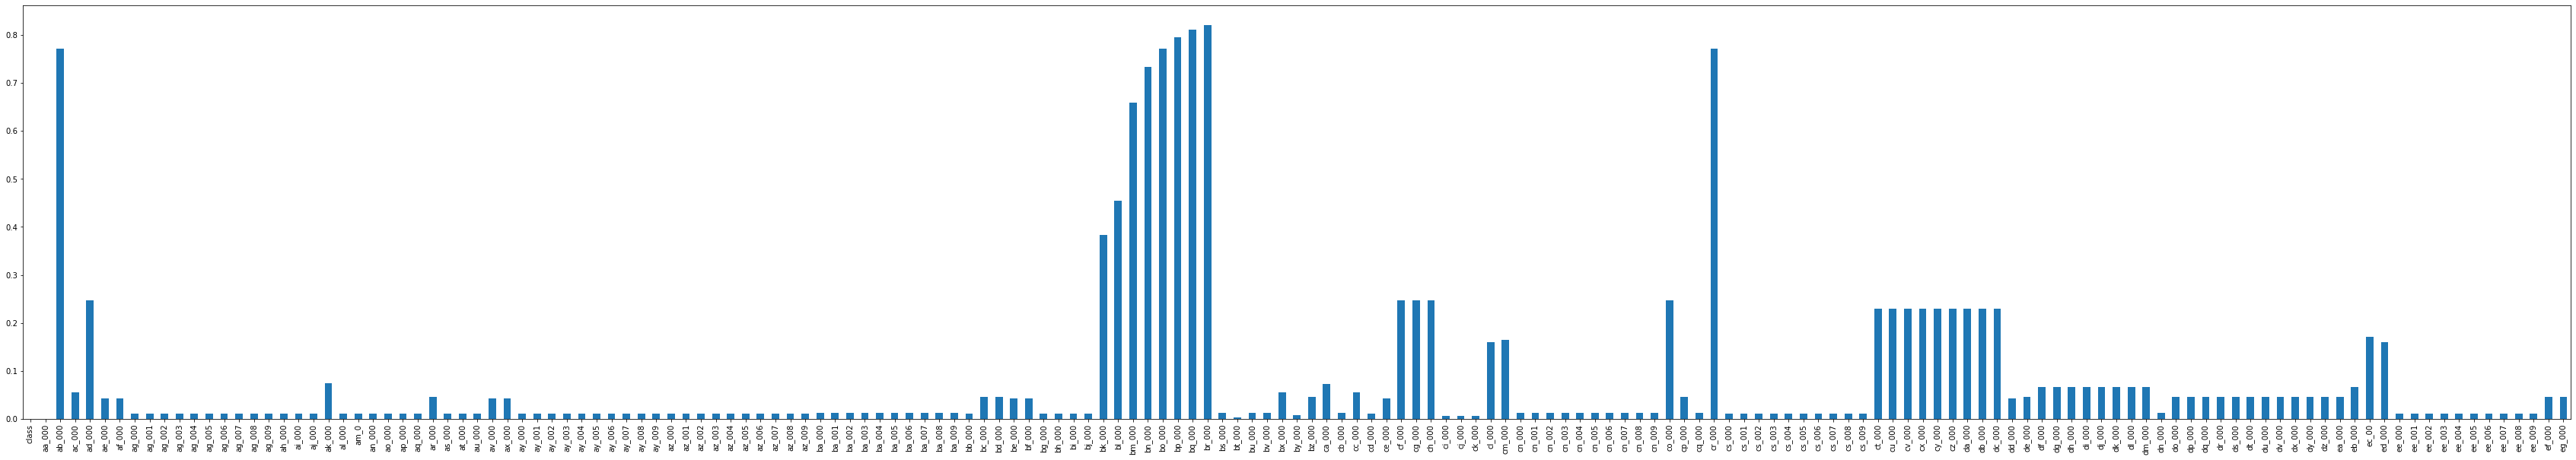

In [5]:
missing = train.isna().sum()/train.shape[0]
missing.plot(kind='bar', figsize=(60, 10));

I'm going to drop columns, which contains of 60% or more missing values.

In [6]:
columns = list(missing[missing>0.6].index)
df_index = [train.columns.get_loc(col) for col in columns]  # For future ColumnTransformer
train.drop(columns, axis=1, inplace=True)
test.drop(columns, axis=1, inplace=True)

Dataset consists of over 170 attributes. This is too much for most of the algorithms, number of
input variables need to be reduced. The correlation heatmap shows that some of them are irrelevant for prediction,
while other are strongly correlated with target variable.

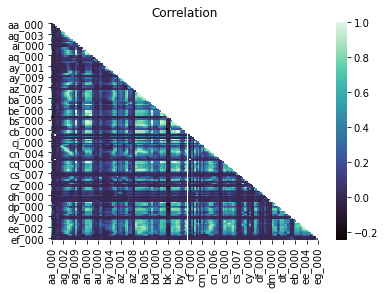

In [7]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap="mako", mask=mask).set_title('Correlation');

I'm going to split here dataset into train and test sets.

In [8]:
y_train = train['class']
X_train = train.drop('class', axis=1)
y_test = test['class']
X_test = test.drop('class', axis=1)

Firstly, We have to fight other missing values. I'll use SimpleImputer which fill missing values
with their mean.

In [9]:
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

I'm also going to standardise data, so it has the same mean and standard deviation
(respectively 0.0 and 1.0)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Principal Component Analysis (PCA) is unsupervised algorithm used to reduce dimensionality of the data.
it uses singular values decomposition to project data to a lower dimensional space. I have set the threshold
for number of components left after decomposition, so dataset after decomposition will still contain 95% of original variance

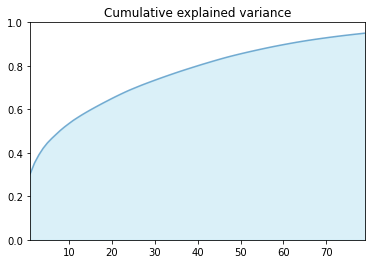

In [11]:
pca = PCA(n_components=.95)
pca.fit(X_train)

plt.fill_between(range(1, 80),np.cumsum(pca.explained_variance_ratio_), color="skyblue", alpha=0.3)
plt.plot(range(1, 80),np.cumsum(pca.explained_variance_ratio_), alpha=0.6)
plt.title("Cumulative explained variance")
plt.xlim(1, 79)
plt.ylim(0, 1);

That way, there are only 79 features left, and we can continue.

In [12]:
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

As the countplot shows dataset is highly imbalanced. It's issue that has to be dealt with.

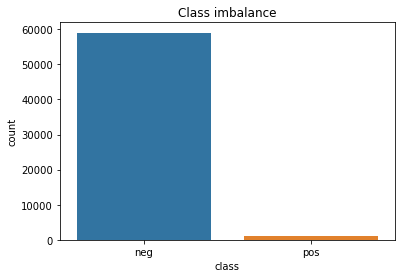

In [13]:
sns.countplot(data=train, x='class').set_title('Class imbalance')
y_train = pd.get_dummies(train['class'], drop_first=True).values.ravel()
y_test = pd.get_dummies(test['class'], drop_first=True).values.ravel()

SMOTEENN is an algorithm used to fight imbalanced data. It combines over-sampling using
SMOTE and under-sampling using Edited Nearest Neighbours.

In [14]:
resampler = SMOTEENN(n_jobs=-1)
X_train, y_train = resampler.fit_resample(X_train, y_train)

Authors of the dataset bring their cost function.

| Predicted value       | 0           | 1  |
| :-------------: |:-------------:| :-----:|
| 0     | - | 10$ |
| 1     | 500$ |  - |

The total cost of a prediction model the sum of Cost_1 multiplied by the number of
instances with type 1 failure and Cost_2 with the number of instances with type 2 failure,
resulting in a total cost (cost of failures). That is the function We will try to minimize.

In [15]:
def cost_function(y, y_true):
    tn, fp, fn, tp = confusion_matrix(y, y_true).ravel()
    cost = 10*fp+500*fn
    return cost

cost_scorer = make_scorer(cost_function, greater_is_better=False)

### Classification Modeling
I'm going to use a few classification models to see with suits my data best.

I will begin with Logistic Regression. Despite the name this algorithm is used to classification tasks.
Since, it is the most basic model, it will serve as benchmark for other more advanced estimators.

In [16]:
clf_logistic = LogisticRegression(max_iter=800)
clf_logistic.fit(X_train, y_train)
y_hat = clf_logistic.predict(X_test)
cost_logistic = cost_function(y_test, y_hat)

KNN is a model that classifies data points based on the points that are most similar to it.

In [17]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
y_hat = clf_knn.predict(X_test)
cost_knn = cost_function(y_test, y_hat)

Decision Tree  tries to predict output by learning simple decision rules inferred from the data features.

In [18]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
y_hat = clf_tree.predict(X_test)
cost_tree = cost_function(y_test, y_hat)

The goal of the SVM algorithm is to create the best decision boundary
that can segregate n-dimensional space into classes so that we can easily put the new
data point in the correct bin in the future.

In [19]:
clf_svm = SVC()
clf_svm.fit(X_train, y_train)
y_hat = clf_svm.predict(X_test)
cost_svm = cost_function(y_test, y_hat)

Now We are moving to estimators based on ensemble techniques. Idea behind Random Forrest regressor is to
combine multiple decision trees in determining the final output rather than relying on individual decision trees.

In [20]:
clf_forrest = RandomForestClassifier()
clf_forrest.fit(X_train, y_train)
y_hat = clf_forrest.predict(X_test)
cost_forrest = cost_function(y_test, y_hat)

Whereas Random Forrest build ensemble of deep independent trees,
Gradient Boosting Regressor build an ensemble of shallow trees in sequence with each tree
learning and improving on the previous.

In [21]:
clf_gboost = GradientBoostingClassifier()
clf_gboost.fit(X_train, y_train)
y_hat = clf_gboost.predict(X_test)
cost_gboost = cost_function(y_test, y_hat)

Summary of classifiers performance shows, that GBM did the best. There is space for future
improvements in grid searching parameters.

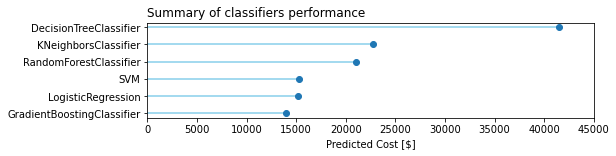

In [22]:
names = ['GradientBoostingClassifier', 'LogisticRegression', 'SVM',
         'RandomForestClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier']
values = [cost_gboost, cost_logistic, cost_svm, cost_forrest,cost_knn, cost_tree]

plt.figure(figsize=(8, 1.75))
plt.hlines(y=names, xmin=0, xmax=values, color='skyblue')
plt.plot(values, names, "o")

plt.yticks(names)
plt.xlim(0, 45000)
plt.title("Summary of classifiers performance", loc='left')
plt.xlabel('Predicted Cost [$]');

What's interesting most faults is type 1 error, while there are only a dozen of type 2 errors.

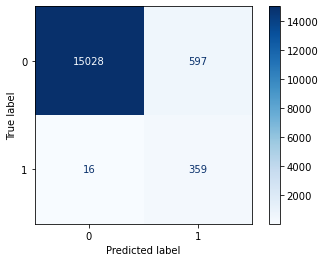

In [23]:
plot_confusion_matrix(clf_gboost, X_test, y_test, cmap='Blues');

### Pipelines, saving models
I'm making 2 pipelines for future predictions. One with resampling and one without.

In [24]:
droper = ColumnTransformer([('droper', 'drop', df_index)])

steps_train = [('droper', droper), ('imputer', imputer), ('scaler', scaler),
                  ('pca', pca), ('resampler', resampler), ('clf', clf_gboost)]
pipeline_train = ImbPipeline(steps_train)

steps_prediction = [('droper', droper), ('imputer', imputer), ('scaler', scaler),
                    ('pca', pca), ('clf', clf_gboost)]
pipeline_prediction = Pipeline(steps_prediction)

dump(pipeline_train, open('../models/pipeline_train.pkl', 'wb'))
dump(pipeline_prediction, open('../models/pipeline_prediction.pkl', 'wb'))